In [33]:
import os
import sys
sys.path.extend(['..'])

import itertools
import random
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import tensorboard
%load_ext tensorboard

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()


print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [34]:
class Agent(tf.keras.Model):
    
    def __init__(
        self, 
        channel_size,
        num_classes,
        name='agent',
        lstm_units=64,
        latent_dim=64,
        encoder=None,
        output_activation=None
    ):
        super(Agent, self).__init__(name=name)
        self.state = None
        self.channel_size = channel_size
        self.num_classes = num_classes
        
        self.concat = tf.keras.layers.Concatenate()
        
        self.encoder = encoder or \
            tf.keras.layers.Lambda(lambda x: x)
        
        self.lstm = tf.keras.layers.LSTM(
            units=lstm_units,
            return_state=True,
            dropout=0.5,
        )

        self.output_layer = tf.keras.layers.Dense(
            self.channel_size + self.num_classes, 
            activation=output_activation
        )
        
        self.extract_utterance = tf.keras.layers.Lambda(
            lambda x: x[:, :self.channel_size]
        )
        self.extract_class_probs = tf.keras.layers.Lambda(
            lambda x: tf.nn.softmax(x[:, self.channel_size:])
        )
        
        self.reset()
        
    def reset(self):
        self.state = self.lstm.get_initial_state(inputs)

    def call(self, inputs, state=None, training=False):
        
        inp, prev_utt, other_utt = inputs
        
        x = self.encoder(inp)
        x = self.concat([x, prev_utt, other_utt])
        
        x = tf.expand_dims(x, 1) # Add time dim
        if state is None:
            state = self.state
        x, *state = self.lstm(x, initial_state=state, 
                              training=training)
        self.state = state
        
        x = self.output_layer(x, training=training)
        
        utterance = self.extract_utterance(x)
        class_probs = self.extract_class_probs(x)
        
        return utterance, class_probs, state


class CommChannel(tf.keras.layers.Layer):
    
    def __init__(self, 
                 size=32,
                 noise=0.5, 
                 temperature=1,
                 no_transform=False,
                 one_hot=True):
        super(CommChannel, self).__init__()
        self.size = size
        self.noise = noise
        self.temperature = temperature
        self.no_transform = no_transform
        self.one_hot = one_hot
        
    def get_initial_state(self, batch_size):
        return tf.zeros((batch_size, self.size))
        
    def call(self, x, training=False):
        if training:
            if self.no_transform:
                return x
            
            if self.noise > 0:
                x = x + tf.random.normal(tf.shape(x),  
                                         mean=tf.zeros_like(x), 
                                         stddev=self.noise)
                
            # The RelaxedOneHotCategorical distribution was concurrently introduced as the
            # Gumbel-Softmax (Jang et al., 2016) and Concrete (Maddison et al., 2016)
            # distributions for use as a reparameterized continuous approximation to the
            # `Categorical` one-hot distribution. If you use this distribution, please cite
            # both papers.
            dist = tfp.distributions.RelaxedOneHotCategorical(
                self.temperature, 
                logits=x
            )
            return dist.sample()
        
        else:
            if self.one_hot:
                x = tf.nn.softmax(x)
                
            x = tf.one_hot(tf.argmax(x, axis=-1), 
                           self.size, dtype=tf.float32)
            return x

## Check that gradients can flow across channel:

In [ ]:
channel = CommChannel(size=10, temperature=1, one_hot=True)

x = tf.Variable([[-1, 2, 4, 0]], dtype=tf.float32)
with tf.GradientTape() as tape:
    y = channel(x, training=True)
    
print(y)
tape.gradient(y, x)

In [ ]:
channel(x)

## Load Data:

In [ ]:
num_classes = 3
class_labels = list(range(num_classes))

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

def preprocess_images(images):
    images = images / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

x_train = preprocess_images(x_train)
train_data = [(x, y) for x, y in zip(x_train, y_train) if y in class_labels]
np.random.shuffle(train_data)

x_test = preprocess_images(x_test)
test_data = [(x, y) for x, y in zip(x_test, y_test) if y in class_labels]
np.random.shuffle(test_data)

train_size = 500
batch_size = 32
test_size = 100

train_data_by_label = {
    label: [
        img for img, l in train_data
        if l == label
    ]
    for label in class_labels
}

test_data_by_label = {
    label: [
        img for img, l in test_data
        if l == label
    ]
    for label in class_labels
}

In [ ]:
def generate_batch(source, source_by_label):
    targets_inputs = [
        (
            tf.constant(random.sample(source_by_label[label], 
                                      batch_size)),
            [tf.one_hot(label, num_classes)] * batch_size
        )
        for label in class_labels
    ]
    random.shuffle(targets_inputs)
    
    inputs = [x for x, _ in targets_inputs]
    targets = [y for _, y in targets_inputs]
    
    source_sample = random.sample(source, batch_size)
    final_input = tf.constant([x for x, _ in source_sample])
    final_target = tf.one_hot([y for _, y in source_sample], 
                              num_classes)
    
    return inputs + [final_input], targets + [final_target]

def generate_train_batch():
    return generate_batch(train_data, train_data_by_label)

def generate_test_batch():
    return generate_batch(test_data, test_data_by_label)

In [ ]:
inputs, targets = generate_train_batch()

In [ ]:
tf.shape(inputs), tf.shape(targets)

In [ ]:
fig, axs = plt.subplots(1, len(class_labels) + 1, 
                        figsize=(10, 10*(1 + len(class_labels))))
for ax, inp in zip(axs, inputs):
    img = inp[0].numpy()
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [10]:
def maybe_mutate_message(
    message, channel_size, history, p_mutate, 
    training=False
):
    batch_size, *_ = tf.shape(message)

    possible_utts = np.array(range(channel_size))

    prev_utts_batch = tf.convert_to_tensor([
        tf.argmax(item['message_from_teacher'], axis=-1) 
        for item in history 
    ])
    prev_utts_batch = tf.reshape(prev_utts_batch, 
                                 (batch_size, len(history)))

    mutations = [
        random.choice(possible_utts[~np.isin(possible_utts, prev_utts)]) 
        for prev_utts in prev_utts_batch
    ]
    if mutations:
        mutations = tf.one_hot(mutations, channel_size)
        mutations = tf.stop_gradient(mutations)

        rand_samples = tf.random.uniform((batch_size, 1))
        mask = tf.cast(rand_samples < p_mutate, tf.float32)

        return mask * mutations + (1 - mask) * message, mask

    return message, None
    

def play_game(
    inputs, teacher, student, comm_channel, 
    p_mutate=0.5, training=False,
    access_to_inputs_in_first_phase=True,
    stop_gradients_on_final_message=True,
    no_protocol_establishment=False,
):
    
    if len(inputs) != num_classes + 1:
        raise ValueError(f'Invalid inputs: {inputs}')

    _, batch_size, *_ = tf.shape(inputs)

    no_inp = tf.zeros_like(inputs[0])
    silence = comm_channel.get_initial_state(batch_size)

    teacher_prev_msg = silence
    history = []
    
    teacher_state = None
    student_state = None

    if not no_protocol_establishment:
        for inp in inputs[:-1]:

            if access_to_inputs_in_first_phase:
                teacher_inputs = (inp, teacher_prev_msg, silence)
            else:
                teacher_inputs = (no_inp, teacher_prev_msg, silence)

            teacher_utterance, _, teacher_state = teacher(
                teacher_inputs, state=teacher_state, training=training
            )

            message_from_teacher = comm_channel(teacher_utterance, 
                                                training=training)
            message_from_teacher, mutations = \
                maybe_mutate_message(message_from_teacher, 
                                     comm_channel.size,
                                     history,
                                     p_mutate,
                                     training=training)

            if access_to_inputs_in_first_phase:
                student_inputs = (inp, silence, message_from_teacher)
            else:
                student_inputs = (no_inp, silence, message_from_teacher)

            _, _, student_state = student(
                student_inputs, state=student_state, training=training
            )

            history.append({
                'teacher_utterance': teacher_utterance,
                'message_from_teacher': message_from_teacher, 
                'message_mutations': mutations
            })
            teacher_prev_msg = message_from_teacher

    teacher_inputs = (inputs[-1], teacher_prev_msg, silence)
    teacher_utterance, _, teacher_state = teacher(
        teacher_inputs, state=teacher_state, training=training
    )

    message_from_teacher = comm_channel(teacher_utterance,
                                        training=training)

    if stop_gradients_on_final_message:
        message_from_teacher = tf.stop_gradient(message_from_teacher)

    student_inputs = (no_inp, silence, message_from_teacher)
    _, student_preds, student_state = student(
        student_inputs, state=student_state, training=training
    )

    history.append({
        'teacher_utterance': teacher_utterance,
        'message_from_teacher': message_from_teacher, 
        'message_mutations': None
    })

    return student_preds, history

## Construct Model

In [11]:
_, *img_shape = x_train.shape
encoder_latent_dim = 64
mnist_encoder = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=img_shape),
        tf.keras.layers.Reshape(target_shape=(*img_shape, 1)),
        tf.keras.layers.Conv2D(
            filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Flatten(),
        # No activation
        tf.keras.layers.Dense(encoder_latent_dim),
    ]
)

comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

agent_1 = Agent(comm_channel.size, num_classes, encoder=mnist_encoder)
agent_2 = Agent(comm_channel.size, num_classes, encoder=mnist_encoder)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

In [12]:
optimizer.get_config()

{'name': 'RMSprop',
 'learning_rate': 0.001,
 'decay': 0.0,
 'rho': 0.9,
 'momentum': 0.0,
 'epsilon': 1e-07,
 'centered': False}

In [13]:
from tensorflow.keras.losses import categorical_crossentropy as cce


def get_correct_teacher_msg(history, targets):
    messages_sent = tf.convert_to_tensor([
        item['message_from_teacher']
        for item in history
    ])

    comm_protocol = tf.convert_to_tensor([
        msg for msg in messages_sent[:-1]
    ])
    comm_protocol = tf.einsum('ijk->jik', comm_protocol)

    # labels for each input in the protocol phase
    protocol_labels = tf.argmax(targets[:-1], axis=-1)
    # labels for the final input
    final_labels = tf.argmax(targets[-1], axis=-1)
    final_labels = tf.reshape(final_labels, (1, batch_size)) 
    idx = protocol_labels == final_labels

    correct_msgs = comm_protocol[tf.transpose(idx)]
    return correct_msgs

def loss_fn(outputs, targets, beta=0.5):
    student_preds, history = outputs
    
    # add student loss
    loss = cce(targets[-1], student_preds)
    
    # add teacher loss
    if len(history) > 1 and beta > 0:
        correct_msg = get_correct_teacher_msg(history, targets)
        actual_msg = history[-1]['message_from_teacher']
        loss = loss + beta * cce(correct_msg, actual_msg)
    
    return loss

Check gradients:

In [14]:
inputs, targets = generate_train_batch()

with tf.GradientTape() as tape:
    outputs = play_game(inputs, agent_1, agent_1, 
                        comm_channel, training=True)
    loss = loss_fn(outputs, targets)

grad = tape.gradient(loss, agent_1.trainable_variables)
for v, g in zip(agent_1.trainable_variables, grad):
    n = tf.reduce_sum(g**2)**0.5
    print(f'{v.name} grad norm: {n}')

Instructions for updating:
Use tf.identity instead.
conv2d/kernel:0 grad norm: 1.239284634590149
conv2d/bias:0 grad norm: 0.48980098962783813
conv2d_1/kernel:0 grad norm: 1.9294112920761108
conv2d_1/bias:0 grad norm: 1.452767014503479
dense/kernel:0 grad norm: 3.0942585468292236
dense/bias:0 grad norm: 2.440875291824341
agent/lstm/kernel:0 grad norm: 2.4867751598358154
agent/lstm/recurrent_kernel:0 grad norm: 0.8125098943710327
agent/lstm/bias:0 grad norm: 3.11277174949646
agent/dense_1/kernel:0 grad norm: 1.11343514919281
agent/dense_1/bias:0 grad norm: 2.795175313949585


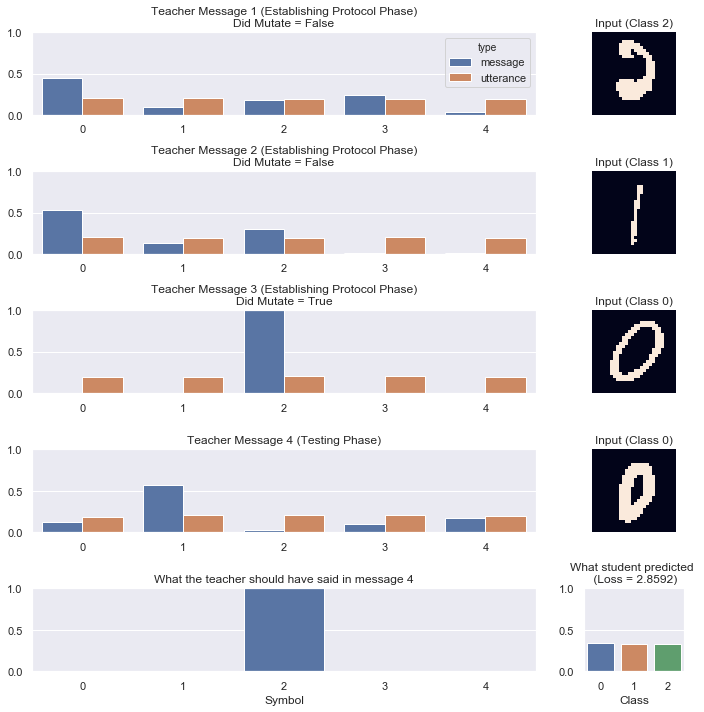

In [15]:
from matplotlib import gridspec

def plot_game(inputs, outputs, targets, select_batch=0):
    """
    Assuming that there is a batch of games, this will only plot
    the first one in the batch
    """
    student_preds, history = outputs
    
    if len(history) > 1:
        fig = plt.figure(figsize=(10, 10)) 
        n_rows = len(history) + 1
    else:
        fig = plt.figure(figsize=(10, 5)) 
        n_rows = 2
    
    chan_size, = history[0]['message_from_teacher'][select_batch].shape
    gs = gridspec.GridSpec(n_rows, 2, width_ratios=[chan_size, 1]) 

    for i, item in enumerate(history):
        ax0 = plt.subplot(gs[2*i])
        vals = tf.stack([
            item['message_from_teacher'][select_batch],
            tf.nn.softmax(item['teacher_utterance'][select_batch]),
        ])
        vals = tf.reshape(vals, (np.prod(vals.shape),))
        types = ['message'] * comm_channel.size + ['utterance'] * comm_channel.size
        x = list(range(comm_channel.size))
        df = pd.DataFrame({
            'x': x+x,
            'y': vals,
            'type': types,
        })
        sns.barplot(data=df, x='x', y='y', hue='type');
        ax0.set_xlabel(''); ax0.set_ylabel('')
        if i > 0:
            plt.legend([],[], frameon=False)
        
        ax0.set_ylim([0, 1])
        ax0.set_yticks([0, 0.5, 1])
        if i < len(history) - 1:
            did_mutate = 1.0 == item['message_mutations'][select_batch][0]
            ax0.set_title(f'Teacher Message {i+1} (Establishing Protocol Phase)\n'
                          f'Did Mutate = {did_mutate}')
        else:
            ax0.set_title(f'Teacher Message {i+1} (Testing Phase)')

        ax1 = plt.subplot(gs[2*i + 1])
        if len(history) != len(inputs):
            ax1.imshow(inputs[-1][select_batch])
        else:
            ax1.imshow(inputs[i][select_batch])
        ax1.set_title(f'Input (Class {tf.argmax(targets[i][select_batch])})')
        ax1.axis('off')

    if n_rows > 2:
        ax = plt.subplot(gs[-2])
        sns.barplot(x=list(range(comm_channel.size)),
                    y=get_correct_teacher_msg(history, targets)[select_batch],
                    palette=sns.color_palette()[:1]);
        ax.set_ylim([0, 1])
        ax.set_yticks([0, 0.5, 1])
        ax.set_title(f'What the teacher should have said in message {i+1}')
        ax.set_xlabel('Symbol')

    ax = plt.subplot(gs[-1])
    _, num_classes = tf.shape(student_preds)
    sns.barplot(x=list(range(num_classes)),
                y=student_preds[select_batch]);
    ax.set_ylim([0, 1])
    loss = loss_fn(outputs, targets)
    ax.set_title(f'What student predicted \n '
                 f'(Loss = {int(loss[select_batch]*10000)/10000})')
    ax.set_xlabel('Class')
    
    plt.tight_layout()
    plt.show()

plot_game(inputs, outputs, targets, select_batch=0)

In [16]:
agent_1.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
sequential (Sequential)      (None, 64)                166336    
_________________________________________________________________
lstm (LSTM)                  multiple                  35584     
_________________________________________________________________
dense_1 (Dense)              multiple                  520       
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0         
Total params: 202,440
Trainable params: 202,440
Non-trainable params: 0
_______________________________________________________

In [17]:
tb_callback = tf.keras.callbacks.TensorBoard()
epochs = 50
steps_per_epoch = 200
step_print_freq = 5

def print_history():
    for e, item in enumerate(training_history):
        mins = int(item['seconds_taken']) // 60
        secs = int(item['seconds_taken']) % 60
        t = f'{mins}:{secs}'
        l = int(10000 * item['loss'].numpy().mean()) / 10000
        print(f'Epoch {e}, Time Taken (mm:ss): {t}, Loss: {l}')


def print_step_progress(step, step_mean_loss):
    l = int(10000 * step_mean_loss.numpy().mean()) / 10000
    p = int(10000 * step/steps_per_epoch) / 100
    print(f'Epoch {epoch}, {p}% complete, Loss: {l}')
    

def self_play_training_step(agent):
    inputs, targets = generate_train_batch()
    
    with tf.GradientTape() as tape:
        outputs = play_game(inputs, agent, agent, 
                            comm_channel, training=True)
        loss = loss_fn(outputs, targets)

    grad = tape.gradient(loss, agent.trainable_variables)
    optimizer.apply_gradients(zip(grad, agent.trainable_variables))

    global mean_loss
    mean_loss = (mean_loss + tf.reduce_mean(loss)) / 2.0

    if step % step_print_freq == 0:
        print_history()
        print_step_progress(step, mean_loss)
        clear_output(wait=True)

In [18]:
epoch = 0
training_history = []

In [19]:
print_history()
try:
    while epoch < epochs:
        mean_loss = tf.zeros((1,))
        
        start_time = time.time()
        for step in range(steps_per_epoch):
            self_play_training_step(agent_1)
        
        seconds_taken = time.time() - start_time
        training_history.append({
            'loss': mean_loss, 
            'seconds_taken': seconds_taken
        })
        
        epoch += 1
        print_history()
        clear_output(wait=True)

except KeyboardInterrupt:
    pass

print_history()
print('Training stopped.')

Epoch 0, Time Taken (mm:ss): 1:16, Loss: 3.6537
Epoch 1, Time Taken (mm:ss): 1:17, Loss: 3.9494
Epoch 2, Time Taken (mm:ss): 1:10, Loss: 4.3902
Epoch 3, Time Taken (mm:ss): 1:19, Loss: 4.9665
Epoch 4, Time Taken (mm:ss): 1:18, Loss: 4.773
Epoch 5, Time Taken (mm:ss): 1:14, Loss: 5.0347
Epoch 6, Time Taken (mm:ss): 1:17, Loss: 4.1514
Epoch 7, Time Taken (mm:ss): 1:13, Loss: 4.1174
Epoch 8, Time Taken (mm:ss): 1:16, Loss: 4.3706
Epoch 9, Time Taken (mm:ss): 1:17, Loss: 4.3808
Epoch 10, Time Taken (mm:ss): 1:12, Loss: 4.9374
Epoch 11, Time Taken (mm:ss): 1:17, Loss: 4.4664
Epoch 12, Time Taken (mm:ss): 1:16, Loss: 5.3064
Epoch 13, Time Taken (mm:ss): 1:14, Loss: 4.1407
Epoch 14, Time Taken (mm:ss): 1:18, Loss: 4.0744
Epoch 15, Time Taken (mm:ss): 1:14, Loss: 4.276
Epoch 16, Time Taken (mm:ss): 1:15, Loss: 4.5843
Epoch 17, Time Taken (mm:ss): 1:18, Loss: 4.5928
Epoch 18, Time Taken (mm:ss): 1:13, Loss: 4.7963
Epoch 19, Time Taken (mm:ss): 1:18, Loss: 4.9512
Epoch 20, Time Taken (mm:ss): 1:

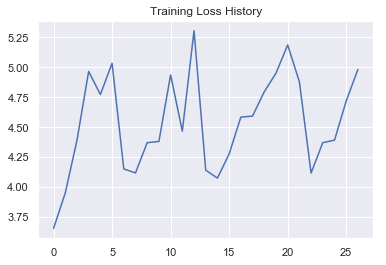

In [20]:
plt.figure()
plt.title('Training Loss History')
sns.lineplot(x=range(len(training_history)), 
             y=[item['loss'].numpy()[0] for item in training_history]);

In [21]:
tf.shape(inputs)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 4, 32, 28, 28])>

In [22]:
test_loss = tf.zeros((1,))
for step in range(50):
    inputs, targets = generate_test_batch()
    outputs = play_game(inputs, agent_1, agent_1, 
                        comm_channel, training=False)
    loss = loss_fn(outputs, targets)
    test_loss = (test_loss + tf.reduce_mean(loss)) / 2
    
print(test_loss)

tf.Tensor([5.1084185], shape=(1,), dtype=float32)


In [23]:
from sklearn.metrics import plot_confusion_matrix

In [24]:
test_samples = [generate_test_batch() for _ in range(50)]

games_played = [
    (x, y, *play_game(x, agent_1, agent_1, comm_channel, p_mutate=1))
    for x, y in test_samples
]

labels = tf.concat([
    tf.argmax(y[-1], axis=-1) 
    for _, y in test_samples
], axis=0)

preds = tf.concat([
    tf.argmax(student_preds, axis=-1) 
    for _, _, student_preds, _ in games_played
], axis=0)

conf_matrix = tf.math.confusion_matrix(labels, preds)

col_totals = tf.reduce_sum(conf_matrix, axis=0)
col_totals = tf.repeat(col_totals, num_classes)
col_totals = tf.reshape(col_totals, tf.shape(conf_matrix))
col_totals = tf.transpose(col_totals)

conf_matrix = (conf_matrix / col_totals).numpy()
conf_matrix[np.where(np.isnan(conf_matrix))] = 0

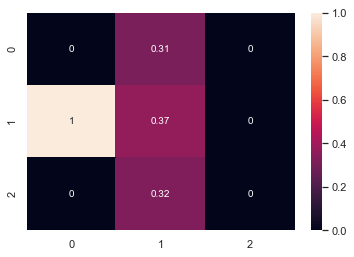

In [32]:
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1);

The rows correspond to the true labels and the columns to the predicted labels. Each column is divided by its sum in order to show the percentage of the time the model predicts the given class.

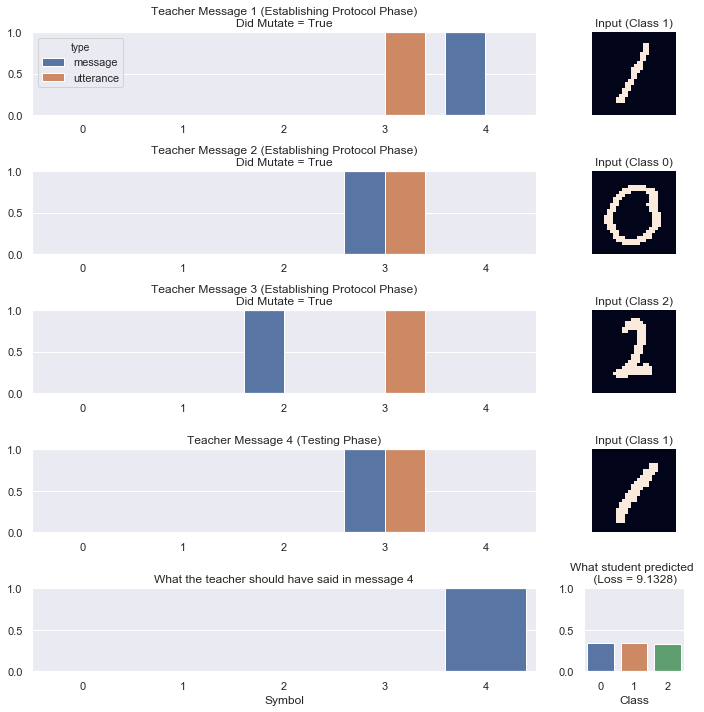

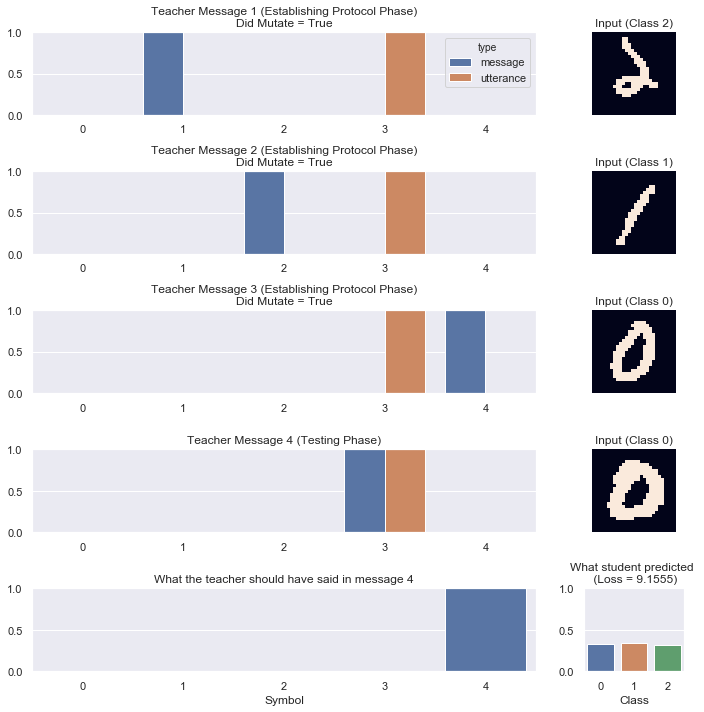

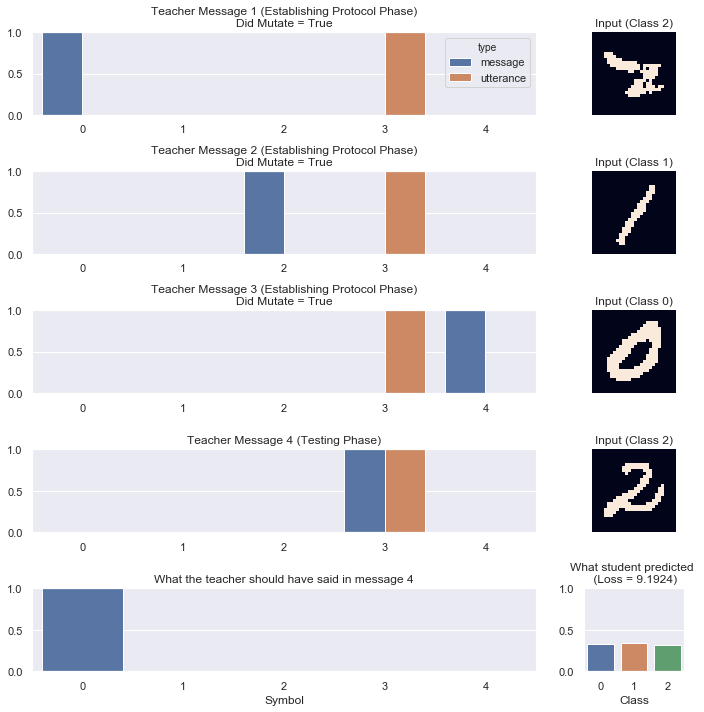

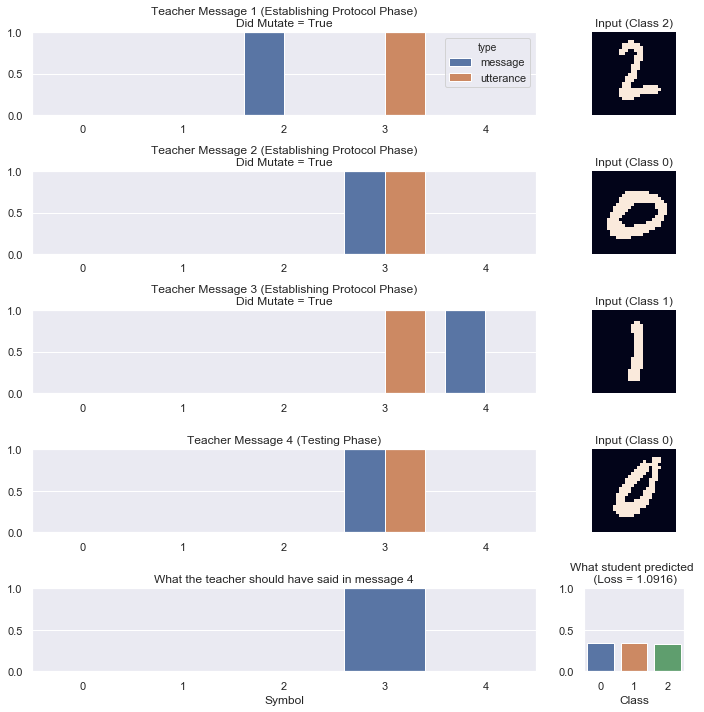

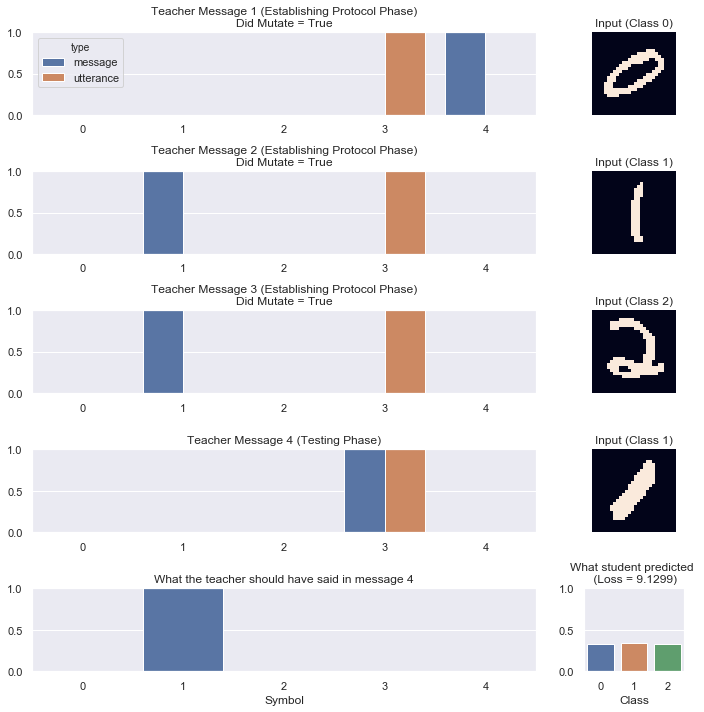

In [26]:
for i in range(5):
    inputs, targets, *outputs = games_played[i]
    plot_game(inputs, outputs, targets)

In [27]:
messages = tf.concat([
    history[-1]['message_from_teacher'] 
    for *_, history in games_played
], axis=0)

In [28]:
def make_lm_map(label, message):
    *_, msg_size = tf.shape(message)
    lm_map_shape = (num_classes, msg_size)
    indices = tf.reshape(tf.repeat(class_labels, msg_size), lm_map_shape)
    indices = tf.cast(indices, tf.int64) == label
    return message * tf.cast(indices, tf.float32)
    
*_, msg_size = tf.shape(messages)
lm_map = tf.zeros((num_classes, msg_size))
for label, message in zip(labels, messages):
    lm_map = lm_map + make_lm_map(label, message)

row_totals = tf.reduce_sum(lm_map, axis=1)
row_totals = tf.repeat(row_totals, comm_channel.size)
row_totals = tf.reshape(row_totals, tf.shape(lm_map))

lm_map = lm_map / row_totals

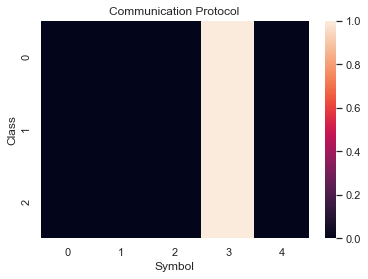

In [29]:
sns.heatmap(lm_map);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [30]:
weights_file = f'models/test/{int(time.time())}'
weights_file

'models/test/1598478368'

In [31]:
model.save_weights(weights_file)

NameError: name 'model' is not defined